# Lunar orbit propagation with degree 100 spherical harmonics gravity model


In [1]:
# Imports
import matplotlib.pyplot as plt
import pykep as pk
import scipy as sp

In [2]:
# Load the gravity model
r_m, mu_m, c, s, max_degree, max_order = pk.util.load_gravity_model("glgm3_150.txt")

In [3]:
# Define initial orbital parameters
# Cartesian elements for Kepler orbit (a, e, i, raan, aop, ta) = (1.788e06, 0.05, 92, 0, 270, 45)
sat0_state0 = sp.array([1.55660045e06,
                       3.35383408e04,
                       -9.60412423e05,
                       9.29725324e02,
                       -4.79891628e01,
                       1.37422982e03])

sat1_state0 = sp.array([-1.71466858e06,
                       2.36328407e04, 
                       -6.76756012e05,
                       6.74391718e02,
                       5.24553880e01,
                       -1.50212578e03])

# Add satellite to propagation list
# states_to_propagate = sp.column_stack((sat0_state0, sat1_state0))
states_to_propagate = sat0_state0

In [4]:
def propagate(t, state):
    acc = pk.util.gravity_spherical_harmonic(sp.array([state[0:3]]), r_m, mu_m, c, s, 100, 100)
    
    delta_state = sp.array([state[3],
                            state[4],
                            state[5],
                            acc[0, 0],
                            acc[0, 1],
                            acc[0, 2]])
    
    return delta_state

In [9]:
time_hist = []
state_hist = []

integrator = sp.integrate.RK45(propagate, 0, states_to_propagate, 3600, rtol=1e-8, atol=1e-8)

while integrator.status == "running":
    integrator.step()
            
    time_hist.append(integrator.t)
    state_hist.append(integrator.y)
    
state_hist = sp.array(state_hist)

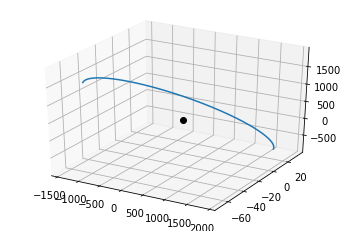

In [10]:
plt.figure(1)
ax = plt.axes(projection='3d')
xline = state_hist[:, 0]/1000
yline = state_hist[:, 1]/1000
zline = state_hist[:, 2]/1000

axis = ax.plot3D(xline, yline, zline)
axis = ax.plot3D([0], [0], [0], 'ko')